In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from collections import defaultdict
from tqdm.notebook import tqdm

c:\Users\repin\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [88]:
# генерируем датафрейм
sample_size = 10_000

metric = np.random.normal(1, 5, sample_size).reshape(1,sample_size)
user_id = np.arange(sample_size).reshape(1,sample_size)
starta_1 = np.random.randint(5, size=sample_size).reshape(1,sample_size)
starta_2 = np.random.randint(3, size=sample_size).reshape(1,sample_size) + 10
cols = ['user_id', 'metric', 'strata_1', 'strata_2']

df = pd.DataFrame(
    data=np.concatenate((user_id, metric, starta_1, starta_2), axis=0).T,
    columns=cols
    )
df

,user_id,metric,strata_1,strata_2
0,0.0,3.463047,3.0,12.0
1,1.0,3.263813,3.0,12.0
2,2.0,14.504332,3.0,11.0
3,3.0,0.619072,4.0,12.0
4,4.0,5.681687,1.0,11.0
...,...,...,...,...
9995,9995.0,-4.187959,1.0,11.0
9996,9996.0,0.410162,0.0,11.0
9997,9997.0,-1.705845,1.0,12.0
9998,9998.0,3.477931,0.0,10.0


In [72]:
titlesize = 24
labelsize = 22
legendsize = 22
xticksize = 18
yticksize = xticksize

plt.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
plt.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = labelsize
plt.rcParams['axes.titlesize'] = titlesize
plt.rcParams['figure.figsize'] = (15, 6)

plt.rc('xtick', labelsize=xticksize)
plt.rc('ytick', labelsize=yticksize)
plt.rc('legend', fontsize=legendsize)

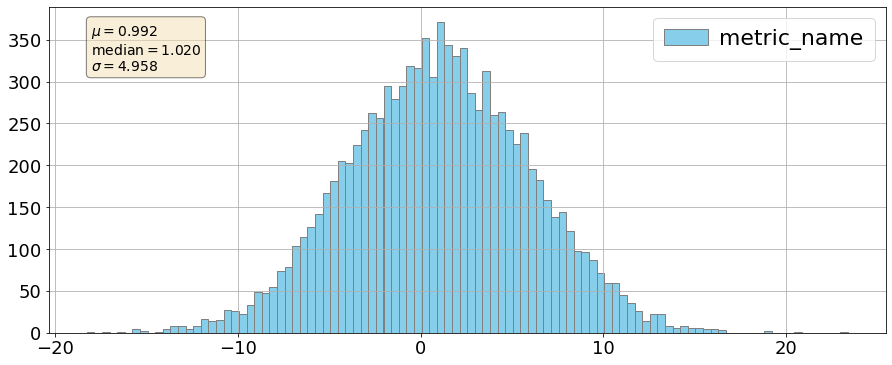

In [89]:
# посмотрим на распределение сырых данных
data_mean = round(np.mean(df['metric']), 4)
data_std = round(np.std(df['metric']), 4)
data_median = round(np.median(df['metric']), 4)

fig, ax = plt.subplots()
ax.hist(df['metric'], color='skyblue', ec='grey', bins=100)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr = '\n'.join((
    r'$\mu=%.3f$' % (data_mean, ),
    r'$\mathrm{median}=%.3f$' % (data_median, ),
    r'$\sigma=%.3f$' % (data_std, )))

ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.legend(['metric_name'])
plt.grid()
plt.show()

In [90]:
# попробуем снизить дисперсию данных за счет стратификации
# TODO изменить функцию так, чтобы не было разбиения на тест и контроль,
def stratified_without_group(data, strat_columns, val_list, group_size, weight, group_count=2):
    strat_df = data[data[strat_columns].isin(val_list).all(axis=1)].reset_index(drop=True)
    print(f'Размер датафрейма страты {val_list}: {len(strat_df)}')
    one_group_size = int(round(group_size * weight)) * group_count
    print(f'one_group_size страты {val_list}: {one_group_size}')
    try:
        random_indexes_for_one_group = np.random.choice([i for i in range(len(strat_df))], one_group_size, False)
        print(f'Количество случайных индексов, всего: {len(random_indexes_for_one_group)}')
        indexes = random_indexes_for_one_group[:one_group_size]
        print(f'Количество отобранных индексов: {len(indexes)}')
    except ValueError:
        print('Объем выборки превышает объем входных данных.')
    random_strata_df = strat_df.iloc[indexes,:]
    print(f'Количество строк в датафрейме страты: {len(random_strata_df)}')
    
    return random_strata_df


def select_stratified_data(data, strat_columns, group_size, weights=None, seed=None):
    """
    Выравнивает общий датафрейм в соответствии с весами

    data - pd.DataFrame, датафрейм с описанием объектов, содержит атрибуты для стратификации.
    strat_columns - List[str], список названий столбцов, по которым нужно стратифицировать.
    weights - dict, словарь весов страт {strat: weight}, где strat - либо tuple значений элементов страт,
        например, для strat_columns=['os', 'gender', 'birth_year'] будет ('ios', 'man', 1992), либо просто строка/число.
        Если None, определить веса пропорционально доле страт в датафрейме data.
    seed - int, исходное состояние генератора случайных чисел для воспроизводимости
        результатов. Если None, то состояние генератора не устанавливается.

    return stratified_data - два датафрейма того же формата, что и data
    """
    # YOUR_CODE_HERE
    np.random.seed(seed)
    
    stratified_df = pd.DataFrame(columns=strat_columns)
    if weights:
        for strata, weight in weights.items():
            if isinstance(strata, (str, int, float)):
                val_list = []
                val_list += [strata]
            else:
                val_list = list(strata)
            try:
                one_strata_df = stratified_without_group(data, val_list, group_size, weight)
                stratified_df = pd.concat([stratified_df, one_strata_df], ignore_index=True)
            except UnboundLocalError:
                print('Нарушена индексация. Проверьте границы входимости индексов в датафрейм')
                return
    else:
        strat_dict = data.groupby(strat_columns).count().iloc[:,0].to_dict()
        len_data = len(df)
        strat_dict_shares = {strata:share/len_data for (strata, share) in strat_dict.items()}
        display(strat_dict_shares)
        for strat, weight in strat_dict_shares.items():
            if isinstance(strat, (str, int, float)):
                val_list = []
                val_list += [strat]
            else:
                val_list = list(strat)
            try:
                one_strata_df = stratified_without_group(data, strat_columns, val_list, group_size, weight)
                stratified_df = pd.concat([stratified_df, one_strata_df], ignore_index=True)
            except UnboundLocalError:
                print('Нарушена индексация. Проверьте границы входимости индексов в датафрейм')
                return  
    return stratified_df

In [94]:
strat_columns = ['strata_1', 'strata_2']
val_list = [0.0, 1.0]
df[df[strat_columns].isin(val_list).all(axis=1)].reset_index(drop=True)

,user_id,metric,strata_1,strata_2


In [84]:
len_df = len(df)
len_strata = len(df[(df['strata_1'] == 0.0) & (df['strata_2'] == 1.0)].reset_index(drop=True))
print(len_strata)
len_strata / len_df

692


0.0692

In [ ]:
df[df[strat_columns].isin(val_list).all(axis=1)].reset_index(drop=True)

In [92]:
t = select_stratified_data(df, ['strata_1', 'strata_2'], 1000, weights=None, seed=42)
t

{(0.0, 10.0): 0.0665,
 (0.0, 11.0): 0.0664,
 (0.0, 12.0): 0.0642,
 (1.0, 10.0): 0.0672,
 (1.0, 11.0): 0.0672,
 (1.0, 12.0): 0.0711,
 (2.0, 10.0): 0.0679,
 (2.0, 11.0): 0.0664,
 (2.0, 12.0): 0.0606,
 (3.0, 10.0): 0.0656,
 (3.0, 11.0): 0.0667,
 (3.0, 12.0): 0.0729,
 (4.0, 10.0): 0.0687,
 (4.0, 11.0): 0.0666,
 (4.0, 12.0): 0.062}

Размер датафрейма страты [0.0, 10.0]: 665
one_group_size страты [0.0, 10.0]: 132
Количество случайных индексов, всего: 132
Количество отобранных индексов: 132
Количество строк в датафрейме страты: 132
Размер датафрейма страты [0.0, 11.0]: 664
one_group_size страты [0.0, 11.0]: 132
Количество случайных индексов, всего: 132
Количество отобранных индексов: 132
Количество строк в датафрейме страты: 132
Размер датафрейма страты [0.0, 12.0]: 642
one_group_size страты [0.0, 12.0]: 128
Количество случайных индексов, всего: 128
Количество отобранных индексов: 128
Количество строк в датафрейме страты: 128
Размер датафрейма страты [1.0, 10.0]: 672
one_group_size страты [1.0, 10.0]: 134
Количество случайных индексов, всего: 134
Количество отобранных индексов: 134
Количество строк в датафрейме страты: 134
Размер датафрейма страты [1.0, 11.0]: 672
one_group_size страты [1.0, 11.0]: 134
Количество случайных индексов, всего: 134
Количество отобранных индексов: 134
Количество строк в датафрейме страты:

,strata_1,strata_2,user_id,metric
0,0.0,10.0,4124.0,2.454356
1,0.0,10.0,4190.0,4.284330
2,0.0,10.0,7047.0,-1.296676
3,0.0,10.0,3365.0,9.452263
4,0.0,10.0,6415.0,6.992868
...,...,...,...,...
1995,4.0,12.0,5890.0,-2.189020
1996,4.0,12.0,614.0,0.314175
1997,4.0,12.0,8525.0,-2.384054
1998,4.0,12.0,7100.0,-2.343771


In [49]:
df

,user_id,metric,starta_1,starta_2
0,0.0,3.418047,3.0,0.0
1,1.0,7.591801,2.0,0.0
2,2.0,3.922886,0.0,1.0
3,3.0,-7.367546,2.0,1.0
4,4.0,8.720459,0.0,1.0
...,...,...,...,...
9995,9995.0,3.833997,4.0,2.0
9996,9996.0,1.192766,3.0,1.0
9997,9997.0,6.925165,1.0,0.0
9998,9998.0,3.002872,3.0,0.0


In [95]:
strat_dict = df.groupby(strat_columns).count().iloc[:,0].to_dict()
len_data = len(df)
strat_dict_shares = {strata:share/len_data for (strata, share) in strat_dict.items()}
df.groupby(strat_columns).count().iloc[:,0]

strata_1  strata_2
0.0       10.0        665
          11.0        664
          12.0        642
1.0       10.0        672
          11.0        672
          12.0        711
2.0       10.0        679
          11.0        664
          12.0        606
3.0       10.0        656
          11.0        667
          12.0        729
4.0       10.0        687
          11.0        666
          12.0        620
Name: user_id, dtype: int64

In [96]:
strat_dict = t.groupby(strat_columns).count().iloc[:,0].to_dict()
len_data = len(t)
strat_dict_shares = {strata:share/len_data for (strata, share) in strat_dict.items()}
strat_dict_shares

{(0.0, 10.0): 0.066,
 (0.0, 11.0): 0.066,
 (0.0, 12.0): 0.064,
 (1.0, 10.0): 0.067,
 (1.0, 11.0): 0.067,
 (1.0, 12.0): 0.071,
 (2.0, 10.0): 0.068,
 (2.0, 11.0): 0.066,
 (2.0, 12.0): 0.061,
 (3.0, 10.0): 0.066,
 (3.0, 11.0): 0.067,
 (3.0, 12.0): 0.073,
 (4.0, 10.0): 0.069,
 (4.0, 11.0): 0.067,
 (4.0, 12.0): 0.062}

In [153]:
# Стратификация с разбиением на пилот и контроль

def stratified_with_group(data, strat_columns, val_list, group_size, weight):
    strat_df = data[data[strat_columns].isin(val_list).all(axis=1)].reset_index(drop=True)
    ab_group_size = int(round(group_size * weight))
    random_indexes_ab = np.random.choice([i for i in range(len(strat_df))], ab_group_size * 2, False)
    a_indexes = random_indexes_ab[:ab_group_size]
    b_indexes = random_indexes_ab[ab_group_size:]
    a_random_strata_df = strat_df.iloc[a_indexes,:]
    b_random_strata_df = strat_df.iloc[b_indexes,:]
    
    return a_random_strata_df, b_random_strata_df

def select_stratified_groups(data, strat_columns, group_size, weights=None, seed=None):
    """
    Подбирает стратифицированные группы для эксперимента.

    data - pd.DataFrame, датафрейм с описанием объектов, содержит атрибуты для стратификации.
    strat_columns - List[str], список названий столбцов, по которым нужно стратифицировать.
    group_size - int, размеры групп.
    weights - dict, словарь весов страт {strat: weight}, где strat - либо tuple значений элементов страт,
        например, для strat_columns=['os', 'gender', 'birth_year'] будет ('ios', 'man', 1992), либо просто строка/число.
        Если None, определить веса пропорционально доле страт в датафрейме data.
    seed - int, исходное состояние генератора случайных чисел для воспроизводимости
        результатов. Если None, то состояние генератора не устанавливается.

    return (data_pilot, data_control) - два датафрейма того же формата, что и data
        c пилотной и контрольной группами.
    """
    # YOUR_CODE_HERE
    np.random.seed(seed)
    
    pilot = pd.DataFrame(columns=strat_columns)
    control = pd.DataFrame(columns=strat_columns)
    if weights:
        for strat, weight in weights.items():
            if isinstance(strat, (str, int, float)):
                val_list = []
                val_list += [strat]
            else:
                val_list = list(strat)
            
            a_random_strata_df = stratified_with_group(data, strat_columns, val_list, group_size, weight)[0]
            b_random_strata_df = stratified_with_group(data, strat_columns, val_list, group_size, weight)[1]
  
            control = pd.concat([control, a_random_strata_df], ignore_index=True)
            pilot = pd.concat([pilot, b_random_strata_df], ignore_index=True)
    else:
        strat_dict = data.groupby(strat_columns).count().iloc[:,0].to_dict()
        len_data = len(data)
        strat_dict_shares = {strata:share/len_data for (strata, share) in strat_dict.items()}
        for strat, weight in strat_dict_shares.items():
            if isinstance(strat, (str, int, float)):
                val_list = []
                val_list += [strat]
            else:
                val_list = list(strat)
            a_random_strata_df = stratified_with_group(data, strat_columns, val_list, group_size, weight)[0]
            b_random_strata_df = stratified_with_group(data, strat_columns, val_list, group_size, weight)[1]
   
            control = pd.concat([control, a_random_strata_df], ignore_index=True)
            pilot = pd.concat([pilot, b_random_strata_df], ignore_index=True)
    return (pilot, control)

In [163]:
pilot = select_stratified_groups(df, ['starta_1', 'starta_2'], 500, weights=None, seed=42)[0]
control = select_stratified_groups(df, ['starta_1', 'starta_2'], 500, weights=None, seed=42)[1]

In [164]:
pilot.groupby(['starta_1', 'starta_2'])['user_id'].count().to_frame()

user_id
starta_1 starta_2         
0.0      0.0           107
         1.0            20
         2.0            18
1.0      0.0             9
         1.0           114
         2.0            15
2.0      0.0            19
         1.0            15
         2.0            86
3.0      0.0            19
         1.0            16
         2.0            17
4.0      0.0            15
         1.0             9
         2.0            25

In [165]:
control.groupby(['starta_1', 'starta_2'])['user_id'].count().to_frame()

user_id
starta_1 starta_2         
0.0      0.0           104
         1.0            11
         2.0            19
1.0      0.0            14
         1.0           102
         2.0            14
2.0      0.0            21
         1.0            18
         2.0            92
3.0      0.0            17
         1.0            17
         2.0            13
4.0      0.0            21
         1.0            14
         2.0            19

In [8]:
def check_ttest(a, b, alpha=0.05):
    """Тест Стьюдента. Возвращает 1, если отличия значимы."""
    _, pvalue = stats.ttest_ind(a, b)
    return int(pvalue < alpha)


def check_mannwhitneyu(a, b, alpha=0.05):
    """Тест Манн-Уитни. Возвращает 1, если отличия значимы."""
    _, pvalue = stats.mannwhitneyu(a, b, alternative='two-sided')
    return int(pvalue < alpha)


def check_bootstrap(a, b, func=np.mean, B=1000, alpha=0.05):
    """Бутстрап. Возвращает 1, если отличия значимы."""
    a_bootstrap = np.random.choice(a, size=(len(a), B))
    b_bootstrap = np.random.choice(b, size=(len(b), B))
    list_diff = func(a_bootstrap, axis=0) - func(b_bootstrap, axis=0)
    left_bound = np.quantile(list_diff, alpha / 2)
    right_bound = np.quantile(list_diff, 1 - alpha / 2)
    res = 1 if (left_bound > 0) or (right_bound < 0) else 0
    return res

In [54]:
res = []
for _ in tqdm(range(100)):
    pval = []
    for _ in range(1000):
        a = np.random.normal(0, 1, 1000)
        b = np.random.normal(0.02, 1, 1000)
        pval.append(check_ttest(a, b))
    res.append(np.mean(pval))

  0%|          | 0/100 [00:00<?, ?it/s]

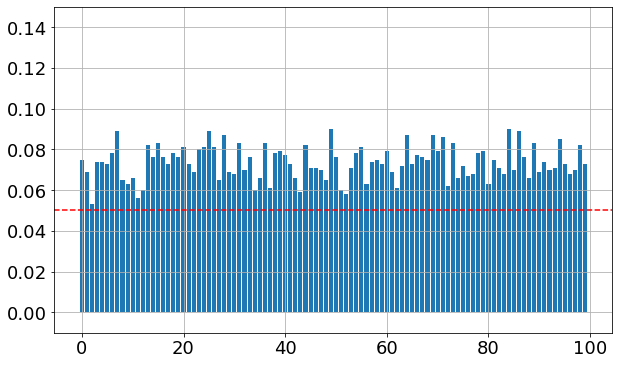

In [55]:
plt.bar([i for i in range(len(res))], res)
plt.ylim([-0.01, 0.15])
plt.axhline(y = 0.05, color = 'r', linestyle = '--')
plt.grid()
plt.show()

In [56]:
np.mean(res)

0.07352999999999998